In [7]:
# vanilla gaussian streamline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib widget
from matplotlib.widgets import Slider
from ipywidgets import interact, FloatSlider
from MFKSGaussClosure import mu_sig_prime, mu_prime, sig_prime
from scipy.integrate import solve_ivp

# Function to create the streamline plot
def plot_vector_field(kappa, k, eps, lbd_spl, r):
    # Create a grid of points
    x = np.linspace(0, 100, 100)
    y = np.linspace(0.001, 10.5, 100)
    X, Y = np.meshgrid(x, y)
    U, V = mu_sig_prime((X, Y), kappa, k, eps, lbd_spl, r)
    # mask = X - 2*Y < 0
    # U[mask] = V[mask] = np.nan   

    fig = plt.figure(figsize=(10, 8))
    strm = plt.streamplot(X, Y, U, V, color=np.sqrt(U**2 + V**2), density=1.6, cmap='winter', norm=LogNorm(1e-7, 1e-1))

    fig.colorbar(strm.lines)
    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),np.max(y))
    plt.xlabel('mu')
    plt.ylabel('sig')
    plt.title('Streamline plot of the vector field')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Interactive sliders
interact(plot_vector_field,
         kappa=FloatSlider(min=0, max=4, step=0.1, value=1.2, description='kappa', continuous_update=False),
         k=FloatSlider(min=0, max=4, step=0.1, value=1, description='k', continuous_update=False),
         eps=FloatSlider(min=0, max=1e-6, step=1e-8, value=0, description='eps', continuous_update=False, readout_format='.1e'),
         lbd_spl=FloatSlider(min=2, max=100, step=1, value=50, description='lbd_spl', continuous_update=False),
         r=FloatSlider(min=0, max=1e-1, step=1e-5, value=1e-3, description='r', continuous_update=False, readout_format='.1e'))




interactive(children=(FloatSlider(value=1.2, continuous_update=False, description='kappa', max=4.0), FloatSlid…

<function __main__.plot_vector_field(kappa, k, eps, lbd_spl, r)>

In [2]:
# streamlines, nullclines & their approximations - interactive 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from matplotlib.colors import LogNorm
from matplotlib.widgets import Slider
from ipywidgets import interact, FloatSlider, Layout, widgets
from MFKSGaussClosure import mu_sig_prime, mu_prime, sig_prime, lbd2_rate_avg, rate_avg, erfc, gauss
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import warnings
import matplotlib.collections
from utils import reparameterize, flexible_scatter, find_roots_rich
warnings.filterwarnings('ignore', category=RuntimeWarning)

def sig_term_r1(mu, sig, kappa, k, eps, lbd_spl, r):
    eps = 0.0
    args = (mu, sig, kappa, k, eps, lbd_spl, r)
    res = - 1/8 * lbd2_rate_avg(*args)
    return res / sig
    
def sig_term_r2(mu, sig, kappa, k, eps, lbd_spl, r):
    eps = 0.0
    args = (mu, sig, kappa, k, eps, lbd_spl, r)
    res = 0.25 * mu**2 * rate_avg(*args)
    return res / sig
    
# Function to create the streamline plot
def plot_vector_field(Drho, Dc, T, epsilon, lbd_spl, r):
    # Create a grid of points
    x = np.linspace(0, 50, 100)
    y = np.linspace(0.001, 6, 100)
    X, Y = np.meshgrid(x, y)
    kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)
    U, V = mu_sig_prime((X, Y), kappa, k, eps, lbd_spl, r)
    
    print(f"µ∞ = {kappa/eps:.1e} (location of epsilon induced µ-nullcline)")
    mu0 = -1/k * np.log(eps/k/kappa)
    print(f"µ0 = {mu0:.2f} (location of maximum of v_M)")    

    plt.close('all')
    fig, ax = plt.subplots(1, figsize=(10, 8))
    # strm = ax.streamplot(X, Y, U, V, color=np.sqrt(U**2 + V**2), density=1.6, cmap='winter', norm=LogNorm(1e-16, 1e-1))
    strm = ax.streamplot(X, Y, U, V, color='grey')
    # fig.colorbar(strm.lines)

    # Plot nullclines and other lines
    lines = []
    labels = []
    initially_invis = []
    
    line1, = ax.plot(mu0 + k * y**2 / 2, y, 'b--', label='$\sigma\' = 0$ (analytic approx)')
    initially_invis.append(line1)
    lines.append(line1)
    labels.append('$\sigma\' = 0$ (analytic approx)')
    
    _x = 2 * y**2 / lbd_spl**2
    line4, = ax.plot(lbd_spl/2 * (1 + _x * np.log(4 * kappa/_x/r/y**2))/(1 + _x), y, 'r--', label='$\mu\' = 0$ (analytic approx)')
    lines.append(line4)
    labels.append('$\mu\' = 0$ (analytic approx)')
    
    line5, = ax.plot(x, np.sqrt(x/k), 'k--', label='$\mu = k \sigma^2$')
    initially_invis.append(line5)
    lines.append(line5)
    labels.append('$\mu = k \sigma^2$')

    line6, = ax.plot(np.sqrt(lbd_spl**2/2 + 2 * y**2), y, 'g--', label='$\sigma^2 = \mu^2/2 - \Lambda_{spl}^2/4$')
    # initially_invis.append(line6)
    lines.append(line6)
    labels.append('$\sigma^2 = \mu^2/2 - \Lambda_{spl}^2/4$')

    sigma_prime_pts = flexible_scatter(fig, ax, x, [find_roots_rich(lambda y: sig_prime(xi, y, kappa, k, eps, lbd_spl, r), y, ()) for xi in x], label='$\sigma\' = 0, \epsilon > 0$')
    lines.append(sigma_prime_pts)
    labels.append('$\sigma\' = 0, \epsilon > 0$')
    
#     sigma_prime_app1_pts = flexible_scatter(fig, ax, x, [find_roots_rich(lambda y: y**2 * k * erfc(-(xi-k*y**2)/y)/gauss(xi-k*y**2, y) - 0.5*(xi**2 + y**2) + eps/kappa * y**2 * xi * (y**2/xi**2 + 1) - y**2 * eps / kappa / gauss(xi, y), y, ()) for xi in x], label='$\sigma\' = 0, \epsilon > 0$ (approx)')
#     initially_invis.append(sigma_prime_app1_pts)
#     lines.append(sigma_prime_app1_pts)
#     labels.append('$\sigma\' = 0, \epsilon > 0$ (approx)')
    
#     sigma_prime_app2_pts = flexible_scatter(fig, ax, x, [find_roots_rich(lambda y: sig_prime(xi, y, kappa, k, eps, lbd_spl, 0.0) + sig_term_r2(xi, y, kappa, k, eps, lbd_spl, r), y, ()) for xi in x], label='$\sigma\' = 0, \epsilon > 0$ (approx2)')
#     initially_invis.append(sigma_prime_app2_pts)
#     lines.append(sigma_prime_app2_pts)
#     labels.append('$\sigma\' = 0, \epsilon > 0$ (approx2)')
    
    mu_prime_pts = flexible_scatter(fig, ax, [fsolve(lambda x: mu_prime(x, yi, kappa, k, eps, lbd_spl, r), k*yi**2) for yi in y], y, marker='+', label='$\mu\' = 0$')
    lines.append(mu_prime_pts)
    labels.append('$\mu\' = 0$')
    
    sigma_prime_eps0_pts = flexible_scatter(fig, ax, x, [find_roots_rich(lambda y: sig_prime(xi, y, kappa, k, 0.0, lbd_spl, r), y, ()) for xi in x], label='$\sigma\' = 0, \epsilon = 0$')
    initially_invis.append(sigma_prime_eps0_pts)
    lines.append(sigma_prime_eps0_pts)
    labels.append('$\sigma\' = 0, \epsilon = 0$')

#     sigma_prime_eps0_app1_pts = flexible_scatter(fig, ax, x, [find_roots_rich(lambda y: y**2 * k * erfc(-(xi-k*y**2)/y)/gauss(xi-k*y**2, y) - 0.5*(xi**2 + y**2), y, ()) for xi in x], label='$\sigma\' = 0, \epsilon = 0$ (approx)')
#     initially_invis.append(sigma_prime_eps0_app1_pts)
#     lines.append(sigma_prime_eps0_app1_pts)
#     labels.append('$\sigma\' = 0, \epsilon = 0$ (approx)')

    mu_prime_eps0_pts = flexible_scatter(fig, ax, [fsolve(lambda x: mu_prime(x, yi, kappa, k, 0.0, lbd_spl, r), k*yi**2) for yi in y], y, marker='+', label='$\mu\' = 0 (\epsilon = 0)$')
    initially_invis.append(mu_prime_eps0_pts)
    lines.append(mu_prime_eps0_pts)
    labels.append('$\mu\' = 0 (\epsilon = 0)$')

#     sig_prime_push_pts = flexible_scatter(fig, ax, x, [find_roots_rich(lambda y: lbd_spl**2 * y / (lbd_spl - xi)**2 * np.exp(-(lbd_spl-xi)**2/2/y**2) - 2 * eps * np.sqrt(2*np.pi) / r, y, ()) for xi in x], label='wish')
#     initially_invis.append(sig_prime_push_pts)
#     lines.append(sig_prime_push_pts)
#     labels.append('wish')


    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y), np.max(y))
    ax.set_xlabel('mu')
    ax.set_ylabel('sig')
    ax.set_title('Streamline plot of the vector field')
    ax.grid()

    # Add legend and make it interactive
    leg = ax.legend(fancybox=True, shadow=True)
    _objs = leg.get_lines() + leg.findobj(matplotlib.collections.PathCollection)
    map_legend_to_ax = {legend_line: line for legend_line, line in zip(_objs, lines)}

    for legend_line in _objs:
        legend_line.set_picker(5)  # Enable picking on the legend line

    def on_pick(event):
        # On the pick event, find the original line corresponding to the legend
        # proxy line, and toggle its visibility.
        legend_line = event.artist
    
        # Do nothing if the source of the event is not a legend line.
        if legend_line not in map_legend_to_ax:
            return
    
        plot_element = map_legend_to_ax[legend_line]
        visible = not plot_element.get_visible()
        plot_element.set_visible(visible)
        # Change the alpha on the line in the legend, so we can see what lines
        # have been toggled.
        legend_line.set_alpha(1.0 if visible else 0.2)
        fig.canvas.draw()
    fig.canvas.mpl_connect('pick_event', on_pick)
    leg.set_draggable(True)

    for el in initially_invis:
        el.set_visible(False)
    
    plt.tight_layout()
    plt.show()


# Interactive sliders
Drho_slider = FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='D_rho:', layout=Layout(width='500px'), continuous_update=False)
Dc_slider = FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='D_c:', layout=Layout(width='500px'), continuous_update=False)
T_slider = FloatSlider(value=5.0, min=0.5, max=10.0, step=0.1, description='T:', layout=Layout(width='500px'), continuous_update=False)
epsilon_slider = widgets.FloatLogSlider(value=1e-6, base=10, min=-8, max=1, step=0.1, description='epsilon:', readout_format='.2e', layout=Layout(width='500px'), continuous_update=False)
lbd_spl_slider = FloatSlider(value=3e1, min=0, max=1e2, step=1, description='lbd_spl:', readout_format='.2e', layout=Layout(width='500px'), continuous_update=False)
r_slider = widgets.FloatLogSlider(value=5e-5, min=-8, max=-1, step=0.1, description='r:', readout_format='.1e', layout=Layout(width='500px'), continuous_update=False)

# Create interactive plot
interactive_plot = interact(plot_vector_field, 
                            Drho=Drho_slider,
                            Dc=Dc_slider,
                            T=T_slider,
                            epsilon=epsilon_slider,
                            lbd_spl=lbd_spl_slider,
                            r=r_slider)

display(interactive_plot)


interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='D_rho:', layout=Layout(widt…

<function __main__.plot_vector_field(Drho, Dc, T, epsilon, lbd_spl, r)>

here
here
here


here
here


In [2]:
# find fold bifurcation - define functions  
from MFKSGaussClosure import *
from utils import reparameterize

# given Drho, Dc, T, and 2 of (r, eps, lbd_spl) find the remaining one where fold happens
# fold <=> equil. & |DF| = 0 <=> equil. & |Df| = 0
def Df_eq(mu, sig, kappa, k, eps, lbd_spl, r):
    args = (mu, sig, kappa, k, eps, lbd_spl, r)
    return np.abs(dmu_f1(*args) * dsig_f2(*args) - dmu_f2(*args) * dsig_f1(*args))
    
# define function of 3 variables (mu, sig, lbd_spl)
def fold_bif_func_lbd_spl(x, *args):
    mu, sig, lbd_spl = x
    kappa, k, eps, r = args
    return [f1(mu, sig, kappa, k, eps, lbd_spl, r),
           f2(mu, sig, kappa, k, eps, lbd_spl, r),
           Df_eq(mu, sig, kappa, k, eps, lbd_spl, r)]

# initial point 
Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e-6 # initial
r = 1e-3 
kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)

fold_bif_func_lbd_spl_ini = [38.5, 5.3, 70.0]


In [3]:
# find fold bifurcation - on epsilon range 
from utils import reparameterize, fixed_point_continuation, balanced_relative_dist
_, _, eps_min, _, _ = reparameterize(Drho, Dc, T, 1e-11, r)
_, _, eps_max, _, _ = reparameterize(Drho, Dc, T, 1e-1, r)

xs_fold_bif_func_lbd_spl_hi, ps_fold_bif_func_lbd_spl_hi = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                         x_ini=fold_bif_func_lbd_spl_ini,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                         p_step=np.array([0.0, 0.0, 1e-3, 0.0]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=1000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))

xs_fold_bif_func_lbd_spl_lo, ps_fold_bif_func_lbd_spl_lo = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                         x_ini=fold_bif_func_lbd_spl_ini,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                         p_step=np.array([0.0, 0.0, -1e-3, 0.0]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=5000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))

xs_fold_bif_func_lbd_spl_eps_range = np.concatenate((xs_fold_bif_func_lbd_spl_lo[::-1, :], xs_fold_bif_func_lbd_spl_hi), 0)
ps_fold_bif_func_lbd_spl_eps_range = np.concatenate((ps_fold_bif_func_lbd_spl_lo[::-1, :], ps_fold_bif_func_lbd_spl_hi), 0)


if False: # plot
    import matplotlib.pyplot as plt
    %matplotlib widget
    fig, ax = plt.subplots()
    ax.plot(ps_fold_bif_func_lbd_spl_eps_range[:, 2], xs_fold_bif_func_lbd_spl_eps_range[:, -1], 'o', label='fold bifurcation')
    ax.grid()
    ax.legend()
    ax.set_xscale('log')
    plt.show()

Worst case timer:  48%|███████████████████████                         | 481/1000 [00:10<00:11, 46.41it/s, rel_step_size=3.00e-02]


Success: Parameter box edge reached. 


Worst case timer:  10%|████▍                                          | 475/5000 [00:14<02:19, 32.34it/s, rel_step_size=-2.82e-02]

Success: Parameter box edge reached. 


In [4]:
# find fold bifurcation - on r range
from utils import reparameterize, fixed_point_continuation, balanced_relative_dist

xs_fold_bif_func_lbd_spl_hi, ps_fold_bif_func_lbd_spl_hi = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                         x_ini=fold_bif_func_lbd_spl_ini,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, -np.inf, 1e-9]), np.array([np.inf, np.inf, np.inf, 1e-1])), 
                         p_step=np.array([0.0, 0.0, 0.0, 1e-3]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=1000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 1.0, 0.8]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1.0, 1+1e-2]))

xs_fold_bif_func_lbd_spl_lo, ps_fold_bif_func_lbd_spl_lo = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                         x_ini=fold_bif_func_lbd_spl_ini,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, -np.inf, 1e-9]), np.array([np.inf, np.inf, np.inf, 1e-1])), 
                         p_step=np.array([0.0, 0.0, 0.0, -1e-3]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=1000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 1.0, 0.8]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1.0, 1+1e-2]))

xs_fold_bif_func_lbd_spl_r_range = np.concatenate((xs_fold_bif_func_lbd_spl_lo[::-1, :], xs_fold_bif_func_lbd_spl_hi), 0)
ps_fold_bif_func_lbd_spl_r_range = np.concatenate((ps_fold_bif_func_lbd_spl_lo[::-1, :], ps_fold_bif_func_lbd_spl_hi), 0)

if False: # plot
    import matplotlib.pyplot as plt
    %matplotlib widget
    fig, ax = plt.subplots()
    ax.plot(ps_fold_bif_func_lbd_spl_r_range[:, 3], xs_fold_bif_func_lbd_spl_r_range[:, -1], 'o', label='fold bifurcation')
    ax.grid()
    ax.legend()
    ax.set_xscale('log')
    plt.show()

Worst case timer:  39%|██████████████████▋                             | 389/1000 [00:09<00:14, 42.78it/s, rel_step_size=1.20e-02]


Success: Parameter box edge reached. 


Worst case timer:  49%|███████████████████████▏                       | 493/1000 [00:09<00:10, 50.69it/s, rel_step_size=-3.38e-02]

Success: Parameter box edge reached. 


In [6]:
# find fold bifurcation - on eps range at any r
r = 1e-7 # arbitrary
_, _, eps_min, _, _ = reparameterize(Drho, Dc, T, 1e-11, r)
_, _, eps_max, _, _ = reparameterize(Drho, Dc, T, 1e1, r)

# take the closest two values as initial conditions 
inds = np.argsort(np.abs(r - ps_fold_bif_func_lbd_spl_r_range[:, -1]))[:2]
weights = np.abs(r - ps_fold_bif_func_lbd_spl_r_range[inds, -1])
x_ini_fold_bif_func_lbd_spl = np.average(xs_fold_bif_func_lbd_spl_r_range[inds, :], axis=0, weights=weights)

# extend to all epsilon
xs_fold_bif_func_lbd_spl_hi, ps_fold_bif_func_lbd_spl_hi = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                         x_ini=x_ini_fold_bif_func_lbd_spl,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                         p_step=np.array([0.0, 0.0, 1e-3, 0.0]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=1000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))

xs_fold_bif_func_lbd_spl_lo, ps_fold_bif_func_lbd_spl_lo = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                         x_ini=x_ini_fold_bif_func_lbd_spl,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                         p_step=np.array([0.0, 0.0, -1e-3, 0.0]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=1000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))

xs_fold_bif_func_lbd_spl = np.concatenate((xs_fold_bif_func_lbd_spl_lo[::-1, :], xs_fold_bif_func_lbd_spl_hi), 0)
ps_fold_bif_func_lbd_spl = np.concatenate((ps_fold_bif_func_lbd_spl_lo[::-1, :], ps_fold_bif_func_lbd_spl_hi), 0)

if False: # plot 
    import matplotlib.pyplot as plt
    %matplotlib widget
    fig, ax = plt.subplots()
    ax.plot(ps_fold_bif_func_lbd_spl[:, 2], xs_fold_bif_func_lbd_spl[:, -1], 'o', label='fold bifurcation')
    ax.grid()
    ax.legend()
    ax.set_xscale('log')
    plt.show()

Worst case timer:  48%|██████████████████████▎                        | 475/1000 [00:06<00:07, 69.09it/s, rel_step_size=-2.82e-02]

Success: Parameter box edge reached. 


In [18]:
# find fold bifurcation - on eps range at any r (interactive)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import interactive, widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
from utils import epsilon_from_eps

epsilon_min = 1e-7
epsilon_max = 1e1

# eps range definition
_, _, eps_min, _, _ = reparameterize(Drho, Dc, T, epsilon_min, r)
_, _, eps_max, _, _ = reparameterize(Drho, Dc, T, epsilon_max, r)

# Function to plot
def plot_functions(r, log_y):


    # take the closest two values as initial conditions 
    inds = np.argsort(np.abs(r - ps_fold_bif_func_lbd_spl_r_range[:, -1]))[:2]
    weights = np.abs(r - ps_fold_bif_func_lbd_spl_r_range[inds, -1])
    x_ini_fold_bif_func_lbd_spl = np.average(xs_fold_bif_func_lbd_spl_r_range[inds, :], axis=0, weights=weights)

    # extend to all epsilon
    xs_fold_bif_func_lbd_spl_hi, ps_fold_bif_func_lbd_spl_hi = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                            x_ini=x_ini_fold_bif_func_lbd_spl,
                            p_old=(kappa, k, eps, r),
                            p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                            p_step=np.array([0.0, 0.0, 1e-3, 0.0]),
                            dist_func=balanced_relative_dist, 
                            dist_tol=0.1,
                            maxiter=1000,
                            p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                            p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))

    xs_fold_bif_func_lbd_spl_lo, ps_fold_bif_func_lbd_spl_lo = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                            x_ini=x_ini_fold_bif_func_lbd_spl,
                            p_old=(kappa, k, eps, r),
                            p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                            p_step=np.array([0.0, 0.0, -1e-3, 0.0]),
                            dist_func=balanced_relative_dist, 
                            dist_tol=0.1,
                            maxiter=1000,
                            p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                            p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))

    xs_fold_bif_func_lbd_spl = np.concatenate((xs_fold_bif_func_lbd_spl_lo[::-1, :], xs_fold_bif_func_lbd_spl_hi), 0)
    ps_fold_bif_func_lbd_spl = np.concatenate((ps_fold_bif_func_lbd_spl_lo[::-1, :], ps_fold_bif_func_lbd_spl_hi), 0)
    
    plt.figure(figsize=(10, 6))
    epsilon_range = epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2])
    kappa_array, k_array, eps_array, lbd_spl_array, r_array = reparameterize(Drho, Dc, T, epsilon_range, r)
    lower_stab_array = -1/k_array * np.log(eps_array / k_array / kappa_array)

    if False: # lines    
        plt.plot(epsilon_range, xs_fold_bif_func_lbd_spl[:, -1], 'o', label='fold bifurcation')
        plt.plot(epsilon_range, lower_stab_array, 'g-', label='argmax v_M')
        ylims = plt.ylim()
        plt.plot(epsilon_range, lbd_spl_array, 'k-', label='KS line')
        plt.ylim(*ylims)

    else: # fill between version
        plt.plot(epsilon_range, xs_fold_bif_func_lbd_spl[:, -1], 'o', alpha=0)
        plt.ylim(11, 31)
        ylims = plt.ylim()
        plt.plot(epsilon_range, lbd_spl_array, 'k-', label='KS line')
        NNN = len(xs_fold_bif_func_lbd_spl[:, -1])
        plt.fill_between(epsilon_range, xs_fold_bif_func_lbd_spl[:, -1], [ylims[1]]*NNN,                 color=(0, 0, 1)    , label='only trivial')
        plt.fill_between(epsilon_range, lower_stab_array,                xs_fold_bif_func_lbd_spl[:, -1],color=(0.5, 0, 0.5), label='bistable')
        plt.fill_between(epsilon_range, [ylims[0]]*NNN,                  lower_stab_array,               color=(1, 0, 0)    , label='only chaos')
        scale_argument = np.asarray([fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30) for eps in eps_array]).flatten()
        # scale_argument2 = - 2 / k_array * np.log(epsilon_range / k_array / kappa_array)
        plt.plot(epsilon_range, scale_argument, 'white', linestyle='--', label='scale argument')
        # plt.plot(epsilon_range, scale_argument2, 'white')
        # plt.fill_between(epsilon_range, scale_argument, [ylims[1]]*NNN,   color=(0, 0, 1), label='only trivial')
        # plt.fill_between(epsilon_range, lower_stab_array, scale_argument, color=(0.5, 0, 0.5), label='bistable')
        # plt.fill_between(epsilon_range, [ylims[0]]*NNN, lower_stab_array, color=(1, 0, 0), label='only chaos')
        
        plt.ylim(*ylims)
        plt.xlim(0.8e-2, 1.05e0)
        plt.ylim(11, 31)

    if log_y:
        plt.yscale('log')
        
    plt.legend()
    plt.xscale('log')
    plt.xlabel('epsilon')
    plt.ylabel('lbd_spl')
    plt.title('Interactive Plot of Functions')
    plt.grid(True)
    plt.show()

# Define sliders and checkboxes
r_slider = widgets.FloatLogSlider(value=1.01e-3, base=10, min=-5, max=-1, step=0.1, readout_format='.2e', continuous_update=False, description='r')
log_y_toggle = widgets.ToggleButton(value=False, description='Log y-axis', button_style='')

# Create interactive plot
interactive_plot = interactive(plot_functions, 
                               r=r_slider,
                               log_y=log_y_toggle)

display(interactive_plot)


interactive(children=(FloatLogSlider(value=0.00101, continuous_update=False, description='r', max=-1.0, min=-5…

In [19]:
plt.close('all')

## Trash

In [6]:
# find transcrit bifurcation - define functions  
from MFKSGaussClosure import *

# given Drho, Dc, T, and 2 of (r, eps, lbd_spl) find the remaining one where transcrit happens
# transcrit <=> sigma-equil. & dsig_F2 = 0 & dmu_F2 = 0
# define function of 3 variables (mu, sig, lbd_spl)
def transcrit_bif_func_lbd_spl(x, *args):
    mu, sig, lbd_spl = x
    kappa, k, eps, r = args
    return [F2(mu, sig, kappa, k, eps, lbd_spl, r),
           dsig_f2(mu, sig, kappa, k, eps, lbd_spl, r) - sig * f1(mu, sig, kappa, k, eps, lbd_spl, r) + 0.5 * (mu**2 - sig**2) * dsig_f1(mu, sig, kappa, k, eps, lbd_spl, r),
            dmu_f2(mu, sig, kappa, k, eps, lbd_spl, r) + mu  * f1(mu, sig, kappa, k, eps, lbd_spl, r) + 0.5 * (mu**2 - sig**2) * dmu_f1(mu, sig, kappa, k, eps, lbd_spl, r)]


In [7]:
# find transcrit bifurcation - on epsilon range 
from utils import reparameterize, fixed_point_continuation, balanced_relative_dist
Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e-6 # initial
r = 1e-3 
kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)
_, _, eps_min, _, _ = reparameterize(Drho, Dc, T, 1e-11, r)
_, _, eps_max, _, _ = reparameterize(Drho, Dc, T, 1e-1, r)

transcrit_bif_func_lbd_spl_ini = [27.0, 1.9, 37.0]

xs_transcrit_bif_func_lbd_spl_hi, ps_transcrit_bif_func_lbd_spl_hi = fixed_point_continuation(func=transcrit_bif_func_lbd_spl, 
                         x_ini=transcrit_bif_func_lbd_spl_ini,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                         p_step=np.array([0.0, 0.0, 1e-3, 0.0]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=1000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))

xs_transcrit_bif_func_lbd_spl_lo, ps_transcrit_bif_func_lbd_spl_lo = fixed_point_continuation(func=transcrit_bif_func_lbd_spl, 
                         x_ini=transcrit_bif_func_lbd_spl_ini,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                         p_step=np.array([0.0, 0.0, -1e-3, 0.0]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=5000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))



xs_transcrit_bif_func_lbd_spl_eps_range = np.concatenate((xs_transcrit_bif_func_lbd_spl_hi, xs_transcrit_bif_func_lbd_spl_lo), 0)
ps_transcrit_bif_func_lbd_spl_eps_range = np.concatenate((ps_transcrit_bif_func_lbd_spl_hi, ps_transcrit_bif_func_lbd_spl_lo), 0)
    
# import matplotlib.pyplot as plt
# %matplotlib widget
# fig, ax = plt.subplots()
# ax.plot(ps_transcrit_bif_func_lbd_spl_eps_range[:, 2], xs_transcrit_bif_func_lbd_spl_eps_range[:, -1], 'o', label='transcrit bifurcation')
# ax.grid()
# ax.legend()
# ax.set_xscale('log')
# plt.show()

Worst case timer:  48%|███████████████████████                         | 481/1000 [00:06<00:06, 80.14it/s, rel_step_size=3.00e-02]


Success: Parameter box edge reached. 


Worst case timer:  10%|████▍                                          | 475/5000 [00:09<01:28, 51.33it/s, rel_step_size=-2.82e-02]


Success: Parameter box edge reached. 


In [8]:
# find transcrit bifurcation - on r range  
Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e-6 
r = 1e-3 # initial
kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)

xs_transcrit_bif_func_lbd_spl_hi, ps_transcrit_bif_func_lbd_spl_hi = fixed_point_continuation(func=transcrit_bif_func_lbd_spl, 
                         x_ini=transcrit_bif_func_lbd_spl_ini,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, -np.inf, 1e-9]), np.array([np.inf, np.inf, np.inf, 1e-1])), 
                         p_step=np.array([0.0, 0.0, 0.0, 1e-3]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=1000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 1.0, 0.8]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1.0, 1+1e-2]))

xs_transcrit_bif_func_lbd_spl_lo, ps_transcrit_bif_func_lbd_spl_lo = fixed_point_continuation(func=transcrit_bif_func_lbd_spl, 
                         x_ini=transcrit_bif_func_lbd_spl_ini,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, -np.inf, 1e-9]), np.array([np.inf, np.inf, np.inf, 1e-1])), 
                         p_step=np.array([0.0, 0.0, 0.0, -1e-3]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=5000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 1.0, 0.8]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1.0, 1+1e-2]))



xs_transcrit_bif_func_lbd_spl_r_range = np.concatenate((xs_transcrit_bif_func_lbd_spl_hi, xs_transcrit_bif_func_lbd_spl_lo), 0)
ps_transcrit_bif_func_lbd_spl_r_range = np.concatenate((ps_transcrit_bif_func_lbd_spl_hi, ps_transcrit_bif_func_lbd_spl_lo), 0)

# import matplotlib.pyplot as plt
# %matplotlib widget
# fig, ax = plt.subplots()
# ax.plot(ps_transcrit_bif_func_lbd_spl_r_range[:, 3], xs_transcrit_bif_func_lbd_spl_r_range[:, -1], 'o', label='transcrit bifurcation')
# ax.grid()
# ax.legend()
# ax.set_xscale('log')
# plt.show()

Worst case timer:  39%|██████████████████▋                             | 389/1000 [00:06<00:10, 59.67it/s, rel_step_size=1.20e-02]


Success: Parameter box edge reached. 


Worst case timer: 100%|██████████████████████████████████████████████| 5000/5000 [01:19<00:00, 62.57it/s, rel_step_size=-1.20e-17]

Terminated at i = 5000. Parameter box edge NOT reached.


Worst case timer:  48%|█████████████████████▊                        | 475/1000 [00:04<00:05, 101.07it/s, rel_step_size=-2.82e-02]


Success: Parameter box edge reached. 


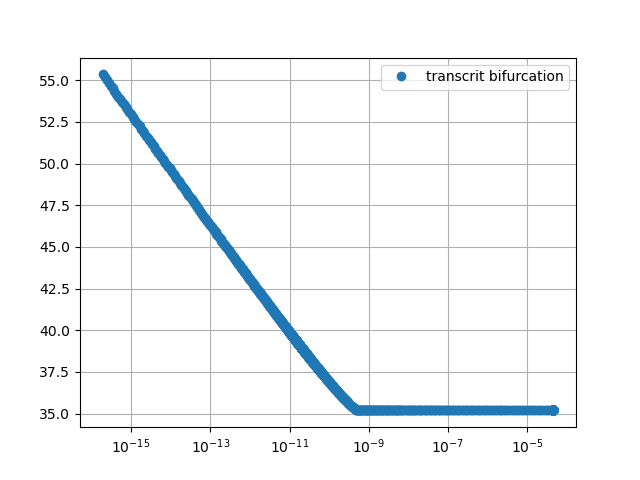

In [18]:
# find transcrit bifurcation - on eps range at any r
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e-6 # initial
r = 1e-6

kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
_, _, eps_min, _, _ = reparameterize(Drho, Dc, T, 1e-11, r)
_, _, eps_max, _, _ = reparameterize(Drho, Dc, T, 1e1, r)


# take the closest two values as initial conditions 
inds = np.argsort(np.abs(r - ps_transcrit_bif_func_lbd_spl_r_range[:, -1]))[:2]
weights = np.abs(r - ps_transcrit_bif_func_lbd_spl_r_range[inds, -1])
x_ini_transcrit_bif_func_lbd_spl = np.average(xs_transcrit_bif_func_lbd_spl_r_range[inds, :], axis=0, weights=weights)

# extend to all epsilon
xs_transcrit_bif_func_lbd_spl_hi, ps_transcrit_bif_func_lbd_spl_hi = fixed_point_continuation(func=transcrit_bif_func_lbd_spl, 
                         x_ini=x_ini_transcrit_bif_func_lbd_spl,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                         p_step=np.array([0.0, 0.0, 1e-3, 0.0]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=1000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))

xs_transcrit_bif_func_lbd_spl_lo, ps_transcrit_bif_func_lbd_spl_lo = fixed_point_continuation(func=transcrit_bif_func_lbd_spl, 
                         x_ini=x_ini_transcrit_bif_func_lbd_spl,
                         p_old=(kappa, k, eps, r),
                         p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                         p_step=np.array([0.0, 0.0, -1e-3, 0.0]),
                         dist_func=balanced_relative_dist, 
                         dist_tol=0.1,
                         maxiter=1000,
                         p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                         p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))



xs_transcrit_bif_func_lbd_spl = np.concatenate((xs_transcrit_bif_func_lbd_spl_hi, xs_transcrit_bif_func_lbd_spl_lo), 0)
ps_transcrit_bif_func_lbd_spl = np.concatenate((ps_transcrit_bif_func_lbd_spl_hi, ps_transcrit_bif_func_lbd_spl_lo), 0)
    
import matplotlib.pyplot as plt
%matplotlib widget
fig, ax = plt.subplots()
ax.plot(ps_transcrit_bif_func_lbd_spl[:, 2], xs_transcrit_bif_func_lbd_spl[:, -1], 'o', label='transcrit bifurcation')
ax.grid()
ax.legend()
ax.set_xscale('log')
plt.show()

In [19]:
# want to explore transcrit_lbd_spl_epsilon_range at any r
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import interactive, widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Function to plot
def plot_functions(n_epsilon, r, log_y):

    kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
    _, _, eps_min, _, _ = reparameterize(Drho, Dc, T, 1e-11, r)
    _, _, eps_max, _, _ = reparameterize(Drho, Dc, T, 1e1, r)
    
    
    # take the closest two values as initial conditions 
    inds = np.argsort(np.abs(r - ps_transcrit_bif_func_lbd_spl_r_range[:, -1]))[:2]
    weights = np.abs(r - ps_transcrit_bif_func_lbd_spl_r_range[inds, -1])
    x_ini_transcrit_bif_func_lbd_spl = np.average(xs_transcrit_bif_func_lbd_spl_r_range[inds, :], axis=0, weights=weights)
    
    # extend to all epsilon
    xs_transcrit_bif_func_lbd_spl_hi, ps_transcrit_bif_func_lbd_spl_hi = fixed_point_continuation(func=transcrit_bif_func_lbd_spl, 
                             x_ini=x_ini_transcrit_bif_func_lbd_spl,
                             p_old=(kappa, k, eps, r),
                             p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                             p_step=np.array([0.0, 0.0, 1e-3, 0.0]),
                             dist_func=balanced_relative_dist, 
                             dist_tol=0.1,
                             maxiter=1000,
                             p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                             p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))
    
    xs_transcrit_bif_func_lbd_spl_lo, ps_transcrit_bif_func_lbd_spl_lo = fixed_point_continuation(func=transcrit_bif_func_lbd_spl, 
                             x_ini=x_ini_transcrit_bif_func_lbd_spl,
                             p_old=(kappa, k, eps, r),
                             p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                             p_step=np.array([0.0, 0.0, -1e-3, 0.0]),
                             dist_func=balanced_relative_dist, 
                             dist_tol=0.1,
                             maxiter=1000,
                             p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                             p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))
    
    
    
    xs_transcrit_bif_func_lbd_spl = np.concatenate((xs_transcrit_bif_func_lbd_spl_hi, xs_transcrit_bif_func_lbd_spl_lo), 0)
    ps_transcrit_bif_func_lbd_spl = np.concatenate((ps_transcrit_bif_func_lbd_spl_hi, ps_transcrit_bif_func_lbd_spl_lo), 0)

    
    plt.figure(figsize=(10, 6))
    plt.plot(ps_transcrit_bif_func_lbd_spl[:, 2], xs_transcrit_bif_func_lbd_spl[:, -1], 'o', label='transcrit bifurcation')
    
    if log_y:
        plt.yscale('log')
        
    plt.legend()
    plt.xscale('log')
    plt.xlabel('epsilon')
    plt.ylabel('Function Value')
    plt.title('Interactive Plot of Functions')
    plt.grid(True)
    plt.show()

# Define sliders and checkboxes
n_epsilon_slider = widgets.IntSlider(value=1000, min=100, max=10000, step=100, continuous_update=False, description='n_epsilon')
r_slider = widgets.FloatLogSlider(value=1.01e-3, base=10, min=-5, max=-1, step=0.1, readout_format='.2e', continuous_update=False, description='r')
log_y_toggle = widgets.ToggleButton(value=False, description='Log y-axis', button_style='')

# Create interactive plot
interactive_plot = interactive(plot_functions, 
                               n_epsilon=n_epsilon_slider,
                               r=r_slider,
                               log_y=log_y_toggle)

display(interactive_plot)


interactive(children=(IntSlider(value=1000, continuous_update=False, description='n_epsilon', max=10000, min=1…

In [9]:
# want to explore transcrit and fold at any r
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import interactive, widgets
from IPython.display import display
import warnings
from utils import epsilon_from_eps
warnings.filterwarnings('ignore', category=RuntimeWarning)

epsilon_min = 1e-7
epsilon_max = 1e1

# Function to plot
def plot_functions(n_epsilon, r, log_y):

    kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
    _, _, eps_min, _, _ = reparameterize(Drho, Dc, T, epsilon_min, r)
    _, _, eps_max, _, _ = reparameterize(Drho, Dc, T, epsilon_max, r)

    # take the closest two values as initial conditions 
    inds = np.argsort(np.abs(r - ps_fold_bif_func_lbd_spl_r_range[:, -1]))[:2]
    weights = np.abs(r - ps_fold_bif_func_lbd_spl_r_range[inds, -1])
    x_ini_fold_bif_func_lbd_spl = np.average(xs_fold_bif_func_lbd_spl_r_range[inds, :], axis=0, weights=weights)
    
    # extend to all epsilon
    print('Fold - high eps')
    xs_fold_bif_func_lbd_spl_hi, ps_fold_bif_func_lbd_spl_hi = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                             x_ini=x_ini_fold_bif_func_lbd_spl,
                             p_old=(kappa, k, eps, r),
                             p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                             p_step=np.array([0.0, 0.0, 1e-3, 0.0]),
                             dist_func=balanced_relative_dist, 
                             dist_tol=0.1,
                             maxiter=1000,
                             p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                             p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))
    
    print('Fold - low eps')
    xs_fold_bif_func_lbd_spl_lo, ps_fold_bif_func_lbd_spl_lo = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                             x_ini=x_ini_fold_bif_func_lbd_spl,
                             p_old=(kappa, k, eps, r),
                             p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                             p_step=np.array([0.0, 0.0, -1e-3, 0.0]),
                             dist_func=balanced_relative_dist, 
                             dist_tol=0.1,
                             maxiter=1000,
                             p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                             p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))
    
    
    
    xs_fold_bif_func_lbd_spl = np.concatenate((xs_fold_bif_func_lbd_spl_hi, xs_fold_bif_func_lbd_spl_lo), 0)
    ps_fold_bif_func_lbd_spl = np.concatenate((ps_fold_bif_func_lbd_spl_hi, ps_fold_bif_func_lbd_spl_lo), 0)
    
    
    # take the closest two values as initial conditions 
    inds = np.argsort(np.abs(r - ps_transcrit_bif_func_lbd_spl_r_range[:, -1]))[:2]
    weights = np.abs(r - ps_transcrit_bif_func_lbd_spl_r_range[inds, -1])
    x_ini_transcrit_bif_func_lbd_spl = np.average(xs_transcrit_bif_func_lbd_spl_r_range[inds, :], axis=0, weights=weights)
    
    # extend to all epsilon
    print('Transcrit - high eps')
    xs_transcrit_bif_func_lbd_spl_hi, ps_transcrit_bif_func_lbd_spl_hi = fixed_point_continuation(func=transcrit_bif_func_lbd_spl, 
                             x_ini=x_ini_transcrit_bif_func_lbd_spl,
                             p_old=(kappa, k, eps, r),
                             p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                             p_step=np.array([0.0, 0.0, 1e-3, 0.0]),
                             dist_func=balanced_relative_dist, 
                             dist_tol=0.1,
                             maxiter=5000,
                             p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                             p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))
    
    print('Transcrit - low eps')
    xs_transcrit_bif_func_lbd_spl_lo, ps_transcrit_bif_func_lbd_spl_lo = fixed_point_continuation(func=transcrit_bif_func_lbd_spl, 
                             x_ini=x_ini_transcrit_bif_func_lbd_spl,
                             p_old=(kappa, k, eps, r),
                             p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                             p_step=np.array([0.0, 0.0, -1e-3, 0.0]),
                             dist_func=balanced_relative_dist, 
                             dist_tol=0.1,
                             maxiter=1000,
                             p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                             p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))
    
    
    
    xs_transcrit_bif_func_lbd_spl = np.concatenate((xs_transcrit_bif_func_lbd_spl_hi, xs_transcrit_bif_func_lbd_spl_lo), 0)
    ps_transcrit_bif_func_lbd_spl = np.concatenate((ps_transcrit_bif_func_lbd_spl_hi, ps_transcrit_bif_func_lbd_spl_lo), 0)

    
    plt.figure(figsize=(10, 6))
    plt.plot(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), xs_fold_bif_func_lbd_spl[:, -1], 'ro', label='fold bifurcation')
    plt.plot(epsilon_from_eps(ps_transcrit_bif_func_lbd_spl[:, 2]), xs_transcrit_bif_func_lbd_spl[:, -1], 'bo', label='transcrit bifurcation')
    # plt.plot(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), xs_fold_bif_func_lbd_spl[:, 0], 'r+', label='fold bifurcation mu')
    # plt.plot(epsilon_from_eps(ps_transcrit_bif_func_lbd_spl[:, 2]), xs_transcrit_bif_func_lbd_spl[:, 0], 'b+', label='transcrit bifurcation mu')
    # plt.plot(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), xs_fold_bif_func_lbd_spl[:, 1], 'r*', label='fold bifurcation sig')
    # plt.plot(epsilon_from_eps(ps_transcrit_bif_func_lbd_spl[:, 2]), xs_transcrit_bif_func_lbd_spl[:, 1], 'b*', label='transcrit bifurcation sig')
    epsilon_range = np.logspace(np.log10(epsilon_min), np.log10(epsilon_max))
    kappa_array, k_array, eps_array, lbd_spl_array, r_array = reparameterize(Drho, Dc, T, epsilon_range, r)
    ylims = plt.ylim()
    plt.plot(epsilon_range, lbd_spl_array, 'k-', label='KS line')
    lower_stab_array = -1/k_array * np.log(eps_array / k_array / kappa_array)
    plt.plot(epsilon_range, lower_stab_array, 'g-', label='lower stability bound')

    # plt.plot(epsilon_range, [fsolve(lambda x: kappa * (np.exp(-k * x) - np.exp(-k * x / 2) + eps * x / 2) , 40) for eps in eps_array], 'g-o')

    plt.ylim(*ylims)
    if log_y:
        plt.yscale('log')
        
    plt.legend()
    plt.xscale('log')
    plt.xlabel('epsilon')
    plt.ylabel('lbd_spl')
    plt.title('Gauss closure phase portrait')
    plt.grid(True)
    plt.show()

# Define sliders and checkboxes
n_epsilon_slider = widgets.IntSlider(value=1000, min=100, max=10000, step=100, continuous_update=False, description='n_epsilon')
r_slider = widgets.FloatLogSlider(value=1.01e-3, base=10, min=-8, max=-1, step=0.1, readout_format='.2e', continuous_update=False, description='r')
log_y_toggle = widgets.ToggleButton(value=False, description='Log y-axis', button_style='')

# Create interactive plot
interactive_plot = interactive(plot_functions, 
                               n_epsilon=n_epsilon_slider,
                               r=r_slider,
                               log_y=log_y_toggle)

display(interactive_plot)


interactive(children=(IntSlider(value=1000, continuous_update=False, description='n_epsilon', max=10000, min=1…

No such comm: 33d1cf99e9fe4a8f831a82d3af283097


In [37]:
# want to explore transcrit and fold at any r
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import interactive, widgets
from IPython.display import display
import warnings
from utils import epsilon_from_eps
warnings.filterwarnings('ignore', category=RuntimeWarning)

epsilon_min = 1e-7
epsilon_max = 1e1

# Function to plot
def plot_functions(n_epsilon, r, log_y):

    kappa, k, eps, _, _ = reparameterize(Drho, Dc, T, epsilon, r)
    _, _, eps_min, _, _ = reparameterize(Drho, Dc, T, epsilon_min, r)
    _, _, eps_max, _, _ = reparameterize(Drho, Dc, T, epsilon_max, r)

    # take the closest two values as initial conditions 
    inds = np.argsort(np.abs(r - ps_fold_bif_func_lbd_spl_r_range[:, -1]))[:2]
    weights = np.abs(r - ps_fold_bif_func_lbd_spl_r_range[inds, -1])
    x_ini_fold_bif_func_lbd_spl = np.average(xs_fold_bif_func_lbd_spl_r_range[inds, :], axis=0, weights=weights)
    
    # extend to all epsilon
    print('Fold - high eps')
    xs_fold_bif_func_lbd_spl_hi, ps_fold_bif_func_lbd_spl_hi = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                             x_ini=x_ini_fold_bif_func_lbd_spl,
                             p_old=(kappa, k, eps, r),
                             p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                             p_step=np.array([0.0, 0.0, 1e-3, 0.0]),
                             dist_func=balanced_relative_dist, 
                             dist_tol=0.1,
                             maxiter=1000,
                             p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                             p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))
    
    print('Fold - low eps')
    xs_fold_bif_func_lbd_spl_lo, ps_fold_bif_func_lbd_spl_lo = fixed_point_continuation(func=fold_bif_func_lbd_spl, 
                             x_ini=x_ini_fold_bif_func_lbd_spl,
                             p_old=(kappa, k, eps, r),
                             p_box=(np.array([-np.inf, -np.inf, eps_min, -np.inf]), np.array([np.inf, np.inf, eps_max, np.inf])), 
                             p_step=np.array([0.0, 0.0, -1e-3, 0.0]),
                             dist_func=balanced_relative_dist, 
                             dist_tol=0.1,
                             maxiter=1000,
                             p_step_decrease_multiplier=np.array([1.0, 1.0, 0.8, 1.0]),
                             p_step_increase_multiplier=np.array([1.0, 1.0, 1+1e-2, 1.0]))
    
    
    
    xs_fold_bif_func_lbd_spl = np.concatenate((xs_fold_bif_func_lbd_spl_lo[::-1, :], xs_fold_bif_func_lbd_spl_hi), 0)
    ps_fold_bif_func_lbd_spl = np.concatenate((ps_fold_bif_func_lbd_spl_lo[::-1, :], ps_fold_bif_func_lbd_spl_hi), 0)
    

    plt.figure(figsize=(10, 6))
    plt.plot(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), xs_fold_bif_func_lbd_spl[:, -1], 'ro-', alpha=0.0, label='fold bifurcation')
    # plt.plot(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), xs_fold_bif_func_lbd_spl[:, 0], 'r+', label='fold bifurcation mu')
    # plt.plot(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), xs_fold_bif_func_lbd_spl[:, 1], 'r*', label='fold bifurcation sig')
    kappa_array, k_array, eps_array, lbd_spl_array, r_array = reparameterize(Drho, Dc, T, epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), r)
    lower_stab_array = -1/k_array * np.log(eps_array / k_array / kappa_array)
    plt.plot(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), lower_stab_array, 'g-', alpha=0.0, label='lower stability bound')
    ylims = plt.ylim()

    # plt.plot(epsilon_range, [fsolve(lambda x: kappa * (np.exp(-k * x) - np.exp(-k * x / 2) + eps * x / 2) , 40) for eps in eps_array], 'g-o')
    NNN = len(xs_fold_bif_func_lbd_spl[:, -1])
    plt.fill_between(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), xs_fold_bif_func_lbd_spl[:, -1], [ylims[1]]*NNN,                 color=(0, 0, 1))
    plt.fill_between(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), lower_stab_array,                xs_fold_bif_func_lbd_spl[:, -1],color=(0.5, 0, 0.5))
    plt.fill_between(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), [ylims[0]]*NNN,                  lower_stab_array,               color=(1, 0, 0))
    scale_argument = np.asarray([fsolve(lambda x: kappa * np.exp(-k * x) - kappa * np.exp(-k * x / 2) + eps * x / 2, 30) for eps in eps_array]).flatten()
    scale_argument2 = - 2 / k_array * np.log(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]) / k_array / kappa_array)
    plt.plot(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), scale_argument, 'white', linestyle='--')
    # plt.plot(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), scale_argument2, 'white')
    # plt.fill_between(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), scale_argument, [ylims[1]]*NNN,   color=(0, 0, 1))
    # plt.fill_between(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), lower_stab_array, scale_argument, color=(0.5, 0, 0.5))
    # plt.fill_between(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), [ylims[0]]*NNN, lower_stab_array, color=(1, 0, 0))
    
    # plt.plot(epsilon_from_eps(ps_fold_bif_func_lbd_spl[:, 2]), lbd_spl_array, 'white', label='predicted physics')

    # plt.ylim(*ylims)
    plt.xlim(0.8e-2, 1.05e0)
    plt.ylim(11, 31)

    if log_y:
        plt.yscale('log')
        
    # plt.legend()
    plt.xscale('log')
    plt.xlabel('epsilon')
    plt.ylabel('lbd_spl')
    plt.title('Gauss closure phase portrait')
    plt.grid(True)
    plt.show()

# Define sliders and checkboxes
n_epsilon_slider = widgets.IntSlider(value=1000, min=100, max=10000, step=100, continuous_update=False, description='n_epsilon')
r_slider = widgets.FloatLogSlider(value=1.01e-3, base=10, min=-8, max=-1, step=0.1, readout_format='.2e', continuous_update=False, description='r')
log_y_toggle = widgets.ToggleButton(value=False, description='Log y-axis', button_style='')

# Create interactive plot
interactive_plot = interactive(plot_functions, 
                               n_epsilon=n_epsilon_slider,
                               r=r_slider,
                               log_y=log_y_toggle)

display(interactive_plot)


interactive(children=(IntSlider(value=1000, continuous_update=False, description='n_epsilon', max=10000, min=1…

In [43]:
# approx functions (old)
from MFKSGaussClosure import gauss, erfc
def g_avg_approx(mu, sig, kappa, k, eps, lbd_spl, r):
    mu_tilde = mu - k * sig**2
    return kappa * np.exp((mu_tilde**2 - mu**2) / 2 / sig**2) + eps * mu

def lbd_g_avg_approx(mu, sig, kappa, k, eps, lbd_spl, r):
    mu_tilde = mu - k * sig**2
    return (kappa * np.exp((mu_tilde**2 - mu**2) / 2 / sig**2) * (sig**2 * gauss(mu_tilde, sig) + mu_tilde) +
            eps * (sig**2 + mu**2))

def rate_avg_approx(mu, sig, kappa, k, eps, lbd_spl, r):
    # return r * sig / np.sqrt(2 * np.pi) - r / 2 * (lbd_spl - mu) + r / np.sqrt(2 * np.pi) * (lbd_spl - mu)**2 / 2 / sig
    return r * np.maximum(mu - lbd_spl, 0)

    # return r * (np.maximum(0, -(lbd_spl - mu)) + np.exp(-np.sqrt(2*np.pi*(lbd_spl - mu)**2)/2) / np.sqrt(2 * np.pi)) 

def lbd2_rate_avg_approx(mu, sig, kappa, k, eps, lbd_spl, r):
    return r * (sig**2 * (2 * sig**2 + mu**2) * gauss(lbd_spl - mu, sig) + 
                (mu**2 * (mu - lbd_spl) + sig**2 * (3 * mu - lbd_spl)) * erfc((lbd_spl - mu) / sig))

from matplotlib.colors import LogNorm, ListedColormap
def create_transparent_cmap(cmap_name, alpha_vals):
    base_cmap = plt.get_cmap(cmap_name)
    base_colors = base_cmap(np.arange(base_cmap.N))

    new_colors = np.zeros_like(base_colors)
    for i, alpha in enumerate(alpha_vals):
        new_colors[i, :] = np.append(base_colors[i, :3], alpha)
    return ListedColormap(new_colors)

# Define alpha values for transparency (0 to 1)
alpha_vals = np.linspace(0, 1, 256)

# Create custom colormap with transparency
transparent_cmap = create_transparent_cmap('Blues', alpha_vals)


In [ ]:
# terms by order of magnitude
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
%matplotlib widget
from matplotlib.widgets import Slider
from ipywidgets import interact, FloatSlider
from MFKSGaussClosure import mu_sig_prime, mu_prime, sig_prime
from scipy.integrate import solve_ivp

def sig_term1(mu, sig, kappa, k, eps, lbd_spl, r):
    eps = 0.0
    lbd_spl = np.inf
    r = 0.0
    args = (mu, sig, kappa, k, eps, lbd_spl, r)
    mu_tilde = mu - k * sig**2
    return kappa * k * sig * np.exp(-k * mu + k**2 * sig**2 / 2) * erfc(- mu_tilde / sig) - eps * sig

def sig_term2(mu, sig, kappa, k, eps, lbd_spl, r):
    eps = 0.0
    lbd_spl = np.inf
    r = 0.0
    args = (mu, sig, kappa, k, eps, lbd_spl, r)
    mu_tilde = mu - k * sig**2
    return sig * gauss(*args) * (eps * mu * (1 + mu**2/sig**2) / 2 + kappa * np.exp(-k * mu + k**2 * sig**2 / 2) * erfc(- mu_tilde / sig) * (1/2 + k * sig**2 / mu + mu**2/sig**2/2) - kappa * (1 + mu**2/sig**2)/2)

def sig_term_eps(mu, sig, kappa, k, eps, lbd_spl, r):
    lbd_spl = np.inf
    r = 0.0
    args = (mu, sig, kappa, k, eps, lbd_spl, r)
    mu_tilde = mu - k * sig**2
    return - eps * sig + sig * gauss(*args) * (eps * mu * (1 + mu**2/sig**2) / 2)

# def sig_term_r1(mu, sig, kappa, k, eps, lbd_spl, r):
#     eps = 0.0
#     args = (mu, sig, kappa, k, eps, lbd_spl, r)
#     res = - 1/8 * lbd2_rate_avg(*args)
#     return res / sig
def sig_term_r1(mu, sig, kappa, k, eps, lbd_spl, r):
    eps = 0.0
    args = (mu, sig, kappa, k, eps, lbd_spl, r)
    res1 = ((mu**2 + sig**2) * rate_avg(mu, sig, kappa, k, eps, lbd_spl, r) + 
            2 * r * mu * sig**2 * erfc((lbd_spl - mu) / sig) / erfc(- mu / sig) + 
            r * sig**4 * gauss(lbd_spl - mu, sig) / erfc(- mu / sig) )
    res2 = r * sig**2 * gauss(lbd_spl - mu, sig) / erfc(- mu / sig) - r * (lbd_spl - mu) * erfc((lbd_spl - mu) / sig) / erfc(- mu / sig)
    res3 = 0.25 * mu**2 * rate_avg(*args) / sig
    return - res1 / 8 / sig - res2 * sig / 4 + res3

# def sig_term_r2(mu, sig, kappa, k, eps, lbd_spl, r):
#     eps = 0.0
#     args = (mu, sig, kappa, k, eps, lbd_spl, r)
#     res = 0.5 * (mu**2 - sig**2) * (0.5 * rate_avg(*args))
#     return res / sig
    
def sig_term_r2(mu, sig, kappa, k, eps, lbd_spl, r):
    eps = 0.0
    args = (mu, sig, kappa, k, eps, lbd_spl, r)
    res = 0.25 * mu**2 * rate_avg(*args)
    return res / sig
    



def plot_functions(kappa, k, eps, lbd_spl, r, funcs_to_plot):
    # Create a grid of points
    x = np.linspace(0, 100, 1000)
    y = np.linspace(0.001, 10, 1000)
    X, Y = np.meshgrid(x, y)
    mask = X - 2*Y < 0

    args = (kappa, k, eps, lbd_spl, r)

    plt.close('all')
    plt.figure(figsize=(10, 6))

    mynorm = SymLogNorm(1e-7, vmin=-1e1, vmax=1e1)
    if 'sig_term1' in funcs_to_plot:
        strm = plt.pcolormesh(x, y, sig_term1(X, Y, *args), cmap='bwr', norm=mynorm)
    if 'sig_term2' in funcs_to_plot:
        strm = plt.pcolormesh(x, y, sig_term2(X, Y, *args), cmap='bwr', norm=mynorm)
    if 'sig_term_eps' in funcs_to_plot:
        strm = plt.pcolormesh(x, y, sig_term_eps(X, Y, *args), cmap='bwr', norm=mynorm)
    if 'sig_term_r1' in funcs_to_plot:
        strm = plt.pcolormesh(x, y, sig_term_r1(X, Y, *args), cmap='bwr', norm=mynorm)
    if 'sig_term_r2' in funcs_to_plot:
        strm = plt.pcolormesh(x, y, sig_term_r2(X, Y, *args), cmap='bwr', norm=mynorm)
        
    plt.colorbar(strm)
    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),np.max(y))
    plt.xlabel('mu')
    plt.ylabel('sig')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Define sliders and checkboxes
kappa_slider = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1, description='kappa', continuous_update=False)
k_slider = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1, description='k', continuous_update=False)
eps_slider = widgets.FloatSlider(value=1e-6, min=0., max=1e-2, step=1e-6, readout_format='.1e',description='eps', continuous_update=False)
lbd_spl_slider = widgets.FloatSlider(value=50, min=0.1, max=100, step=1, description='lbd_spl', continuous_update=False)
r_slider = widgets.FloatSlider(value=1, min=0.0, max=5, step=0.1, description='r', continuous_update=False)
funcs_checkboxes = widgets.SelectMultiple(
    options=['sig_term1', 'sig_term2', 'sig_term_eps', 'sig_term_r1', 'sig_term_r2'],
    value=['sig_term1'],
    description='Functions'
)

# Create interactive plot
interactive_plot = interactive(plot_functions, 
                               mu=mu_slider, 
                               sig=sig_slider, 
                               kappa=kappa_slider, 
                               k=k_slider, 
                               eps=eps_slider, 
                               lbd_spl=lbd_spl_slider, 
                               r=r_slider, 
                               funcs_to_plot=funcs_checkboxes
            )

display(interactive_plot)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[-2.6  1.   0.  ...  0.   0.   0. ]
 [ 2.6 -2.   1.  ...  0.   0.   0. ]
 [ 0.   1.  -2.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ... -2.   1.   0. ]
 [ 0.   0.   0.  ...  1.  -2.   1. ]
 [ 0.   0.   0.  ...  0.   1.  -1. ]]
